## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    2. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    3. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    2. Try a few options for k. Record your observations.
    3. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    4. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    


In [1]:
# # # !pip install gdown --upgrade
# # !gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
# !gdown 1hVX-6qZqxMNDrk_EX96vm4VleTPP911f
# # #image embeddings
# # !gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
# !gdown 1o5ho04HsXFNpH318rkRFXg9IWx-pHEhX
# # #caption embeddings

# !pip install faiss-cpu

# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# !unzip /content/annotations_trainval2014.zip
# !wget http://images.cocodataset.org/zips/val2014.zip
# !unzip /content/val2014.zip

# import os

# # List all files in the current directory
# files = os.listdir()
# # Loop through all files
# for file in files:
#     # Check if the file is a .zip file
#     if file.endswith('.zip'):
#         os.remove(file)
#         # If it is a .zip file, delete it
#         # print(file)


In [2]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
# from nltk.translate.bleu_score import SmoothingFunction

loading annotations into memory...
Done (t=1.33s)
creating index...


index created!
Number of samples:  40504


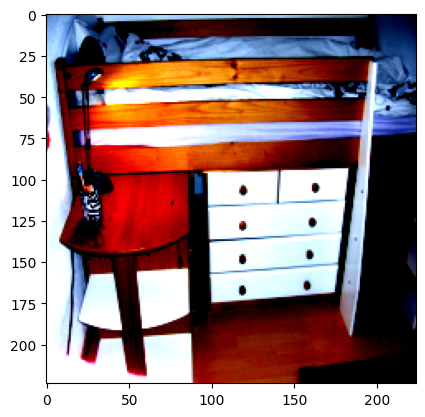

Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']
<class 'list'>


In [3]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014', annFile = '/content/annotations/captions_val2014.json', transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample
plt.imshow(img.permute(1,2,0))
plt.show()
print("Image Size: ", img.shape)
print(target)
print(type(target))

In [4]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
print(ids)
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)
print(captions_np[3])

[42, 73, 74, 133, 136, 139, 143, 164, 192, 196, 208, 241, 257, 283, 285, 294, 328, 338, 357, 359, 360, 387, 395, 397, 400, 415, 428, 459, 472, 474, 486, 488, 502, 520, 536, 544, 564, 569, 589, 590, 599, 623, 626, 632, 636, 641, 661, 675, 692, 693, 699, 711, 715, 724, 730, 757, 761, 764, 772, 775, 776, 785, 802, 810, 827, 831, 836, 872, 873, 885, 923, 939, 962, 969, 974, 985, 987, 999, 1000, 1029, 1063, 1064, 1083, 1089, 1103, 1138, 1146, 1149, 1153, 1164, 1171, 1176, 1180, 1205, 1228, 1244, 1268, 1270, 1290, 1292, 1296, 1340, 1342, 1347, 1353, 1369, 1374, 1393, 1398, 1404, 1425, 1436, 1442, 1448, 1464, 1490, 1503, 1525, 1532, 1554, 1561, 1563, 1573, 1577, 1584, 1590, 1591, 1592, 1599, 1626, 1647, 1655, 1667, 1668, 1675, 1682, 1700, 1722, 1739, 1757, 1761, 1779, 1799, 1803, 1818, 1840, 1841, 1852, 1856, 1869, 1903, 1948, 1955, 1960, 1987, 1993, 2006, 2014, 2061, 2124, 2139, 2142, 2149, 2153, 2154, 2157, 2164, 2171, 2179, 2191, 2212, 2225, 2235, 2239, 2240, 2255, 2261, 2290, 2295, 2299, 

In [5]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [6]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)
print(caption_embeddings[0])

Caption embeddings (40504, 5, 512)
[[-2.9846387e-02 -2.7121352e-02  5.2404514e-05 ...  4.0988393e-02
   3.2700416e-02 -2.7879201e-02]
 [-3.5480466e-02 -3.9461046e-02 -1.0539140e-02 ...  5.0266604e-03
  -1.4535394e-03 -7.7456799e-03]
 [-7.0352077e-02 -1.0378881e-02 -8.2088262e-03 ...  3.5793733e-02
   2.7698692e-02 -3.0689629e-02]
 [-3.7009135e-02 -1.5057037e-02 -3.0805115e-02 ... -4.7336374e-03
  -1.2907129e-02 -1.5533088e-02]
 [-2.2119718e-02 -3.3564340e-02 -1.2214145e-02 ...  2.1481177e-02
  -1.2828127e-02 -4.8627362e-02]]


In [7]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [8]:
# print(len(caption_embeddings[1][1]))
# print(len(image_embeddings[1]))
dict_image_embeddings = {tuple(row): i for i, row in enumerate(image_embeddings)}
dict_caption_embeddings = {tuple(caption_embeddings[i][j]): [i, j] for i in range(caption_embeddings.shape[0]) for j in range(caption_embeddings.shape[1])}
# print(dict_caption_embeddings.values)

In [9]:
train_image_embeddings, test_image_embeddings, train_caption_embeddings, test_caption_embeddings = train_test_split(
    image_embeddings, caption_embeddings, test_size=0.2, random_state=42)

# image_embeddings_to_image_map = []
# for embedding in train_image_embeddings:
#     image_embeddings_to_image_map.append(np.where((image_embeddings == embedding).all(axis=1))[0][0])
# for embedding in test_image_embeddings:
#     image_embeddings_to_image_map.append(np.where((image_embeddings == embedding).all(axis=1))[0][0])

# print(len(image_embeddings_to_image_map))
print(train_caption_embeddings.shape)
print(test_caption_embeddings.shape)
print(train_image_embeddings.shape)
print(test_image_embeddings.shape)
print(len(test_caption_embeddings))

(32403, 5, 512)
(8101, 5, 512)
(32403, 512)
(8101, 512)
8101


In [10]:
test_captions = []
lnt = len(test_caption_embeddings)
for i in range(lnt):
    img_idx = dict_image_embeddings[tuple(test_image_embeddings[i])]
    # test_img, testcaps = coco_dset[img_idx]
    testcaps = coco_dset[img_idx][1]
    test_captions.append(testcaps)
# print(len(test_captions))
# print(test_captions[0])

8101
['A woman sitting at a table with birthday decorations.', 'a woman is sitting with a birthday cake and some candles', 'A woman sitting in front of a birthday cake, posing for a picture.', 'A women who is sitting by a birthday cake.', 'A woman sitting at a table with a cake with candles.']


In [11]:
# K = [1, 3, 5, 7, 9, 11, 13, 15]
for k in range(1, 26):
    print(f'for k = {k} : \n')

    # Assuming 'test_image_embeddings' is your array of image embeddings

    # Dimension of the vectors
    # d = test_image_embeddings.shape[1]


    D, I = faiss.knn(test_image_embeddings,train_image_embeddings,k)
    # Build the index
    # index = faiss.IndexFlatL2(d)

    # Add vectors to the index
    # index.add(test_image_embeddings)

    # Perform a search
    # Let's say we want to find the 5 nearest neighbors

    # Use a random vector as an example query
    # In practice, you'd use your actual query vector
    # query = np.random.random((1, d)).astype('float32')

    # D, I = index.search(query, k)

    # print(D)
    # print(I)
    # print(D.shape)
    # print(I.shape)

    # print(type(D))
    # print(type(I))
    # D contains the distances to the nearest neighbors
    # I contains the indices of the nearest neighbors





    # for nns,image,d in zip(I,test_caption_embeddings,D):
    #     print(nns,d)

    # Assuming 'train_image_embeddings' and 'train_caption_embeddings' are your arrays of image and caption embeddings
    # 'D' and 'I' are the distances and indices of the k nearest neighbors found by faiss.knn
    # 'Z' is your normalization constant

    # def calculate_similarity(D, Z):
    #     sim = 1 - D / Z
    #     return sim

        # N, k = I.shape
        # M = len(train_caption_embeddings[0]) # assuming each image has the same number of captions
        # print(N)
        # print(k)
        # print(M)
        # print(train_caption_embeddings.shape)
        # print(train_caption_embeddings[I[0][0]])
        # q = np.zeros_like(train_caption_embeddings[0][0])
        # print(q.shape)
        # for i in range(N):
        #     sim = []
        #     for j in range(k):
        #         sim.append(1 - D[i][j])
        #         # print(sim)
        #     q += sim * train_caption_embeddings[I[i][j]]
        # q /= (N * M)
    # def query_expansion(IDX, test_image_embedding,d,k):
    #     q = np.zeros(512)
    #     for nn,dist in zip(IDX,d):
    #         sim_factor = 1 - dist
    #         for caption_embed in train_caption_embeddings[nn]:
    #             q += sim_factor*(caption_embed)
    #         # print(sim_factor, )
    #     return q/k/5

    def query_expansion(IDX,DIS,k):
        q = np.zeros(512)
        # OUT_COUNT = 0
        for NN,dist in zip(IDX,DIS):
            # q_dash = np.zeros(512)
            sim_factor = 1 - dist
            # IN_COUNT = 0
            # OUT_COUNT += 1
            for caption_embed in train_caption_embeddings[NN]:
                q += sim_factor*(caption_embed)
                # IN_COUNT += 1
                # q_dash += caption_embed
            # q += sim_factor * q_dash
            # print(sim_factor, )
        # print(OUT_COUNT, IN_COUNT)
        return q/k/5

    # queries_list = []
    # for image,IDX,d in zip(test_image_embeddings,I,D):
    #     q = query_expansion(IDX,image,d)
    #     queries_list.append(q)
    queries_list = np.array([query_expansion(IDX,DIS,k) for IDX,DIS in zip(I,D)])
    #     q = query_expansion(IDX,image,d)
    #     queries_list.append(q)
    # print(len(queries_list))
    # print(len(queries_list[0]))
    # print(type(queries_list))
    # queries_list = np.array(queries_list)
    # print(queries_list.shape)

    # def re_rank_captions(q, train_caption_embeddings):
    #     caption_vectors = np.vstack([c for captions in train_caption_embeddings for c in captions])
    #     distances = cosine_distances(q.reshape(1, -1), caption_vectors)
    #     closest_caption_index = np.argmin(distances)

    #     return train_caption_embeddings[closest_caption_index // len(train_caption_embeddings[0])][closest_caption_index % len(train_caption_embeddings[0])]

    # Usage:
    # I_q is your query image vector
    # candidate_set is your set of (image_vector, list_of_caption_vectors) pairs
    # Z is your normalization constant
    # q = query_expansion(I_q, D, I, train_caption_embeddings, Z)
    # closest_caption = re_rank_captions(q, train_caption_embeddings)



    # queries_list = np.array(queries_list)

    pred_captions = max_similar_caption_per_image_query = []
    for image_query, id_list  in zip(queries_list, I):
        # print(np.linalg.norm(image_query))
        simi_value = -1
        for id in id_list:
            num = -1
            for cap_embed in train_caption_embeddings[id]:
                similarity_of_one_caption = np.dot(image_query, cap_embed) / np.linalg.norm(image_query)
                # because np.linalg.norm(cap_embed) = 1
                num += 1
                if(simi_value < similarity_of_one_caption):
                    simi_value = similarity_of_one_caption
                    best_cap_embed = cap_embed
                    # best_image_id = dict_image_embeddings[tuple(train_image_embeddings[id])]
                    # best_image_cap_id = train_caption_embeddings[id].index(cap_embed)
                    # best_image_cap_id = num
                    [best_image_id, best_image_cap_id] = dict_caption_embeddings[tuple(cap_embed)]
                # similarities_wrt_one_image_query.append(similarity_of_one_caption)
        max_similar_caption_per_image_query.append(captions_np[best_image_id][best_image_cap_id])
    # max_similar_caption_per_image_query = np.array(max_similar_caption_per_image_query)
    # print(len(max_similar_caption_per_image_query))
    # print(best_image_id, best_image_cap_id)
    # print(max_similar_caption_per_image_query

    # del dict_caption_embeddings

    # test_captions = []
    # for i in range(len(test_caption_embeddings)):
    #     _, testcaps = coco_dset[dict_image_embeddings[tuple(test_image_embeddings[i])]]
    #     test_captions.append(testcaps)
    # # print(len(test_captions))




    def accuracy(predict, real, number):
        '''
        use bleu score as a measurement of accuracy
        :param predict: a list of predicted captions
        :param real: a list of actual descriptions
        :return: bleu accuracy
        '''
        # weightList = [(1.,), (1./2., 1./2.), (1./3., 1./3., 1./3.), (1./4., 1./4., 1./4., 1./4.), (1./5., 1./5., 1./5., 1./5., 1./5.)]
        # weightList = (1./4., 1./4., 1./4., 1./4.)
        weightList = (1.,)
        accuracy = 0
        for i, pre in enumerate(predict):
            references = real[i]
            score = bleu_score.sentence_bleu(references, pre, weightList, getattr(bleu_score.SmoothingFunction(), f'method{number}'))
            accuracy += score
        return accuracy/len(predict)

    def accuracy_v2(predict, real, number):
        '''
        use bleu score as a measurement of accuracy
        :param predict: a list of predicted captions
        :param real: a list of actual descriptions
        :return: bleu accuracy
        '''
        lower_n_split = lambda x: x.lower().split()
        # weightList = [(1.,), (1./2., 1./2.), (1./3., 1./3., 1./3.), (1./4., 1./4., 1./4., 1./4.), (1./5., 1./5., 1./5., 1./5., 1./5.)]
        # weightList = (1./4., 1./4., 1./4., 1./4.)
        weightList = (1.,)
        accuracy = 0
        for i, pre in enumerate(predict):
            refs = real[i]
            accuracy += bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre), weightList, getattr(bleu_score.SmoothingFunction(), f'method{number}'))
            # = score
        return accuracy/len(predict)

    print()
    # print(accuracy(pred_captions, test_captions, 0), accuracy_v2(pred_captions, test_captions, 0))
    # print(accuracy(pred_captions, test_captions, 1), accuracy_v2(pred_captions, test_captions, 1))
    # print(accuracy(pred_captions, test_captions, 2), accuracy_v2(pred_captions, test_captions, 2))
    # print(accuracy(pred_captions, test_captions, 3), accuracy_v2(pred_captions, test_captions, 3))
    # print(accuracy(pred_captions, test_captions, 4), accuracy_v2(pred_captions, test_captions, 4))
    # print(accuracy(pred_captions, test_captions, 5), accuracy_v2(pred_captions, test_captions, 5))
    # # print(accuracy(pred_captions, test_captions, 6), accuracy_v2(pred_captions, test_captions, 6))
    # print(accuracy(pred_captions, test_captions, 7), accuracy_v2(pred_captions, test_captions, 7))
    print(accuracy_v2(pred_captions, test_captions, 0))
    '''
    print(accuracy_v2(pred_captions, test_captions0))
    print(accuracy_v2(pred_captions, test_captions1))
    print(accuracy_v2(pred_captions, test_captions2))
    print(accuracy_v2(pred_captions, test_captions3))
    print(accuracy_v2(pred_captions, test_captions4))
    print(test_captions[0])
    print(pred_captions[0])
    print(pred_captions[1])
    '''
    # print('-----------------------------------------------------------------------------------------------------------')
    # print('-----------------------------------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------------------------------')
    print('\n\n')

# del dict_caption_embeddings

for k = 1 : 


0.5327622495767522
-----------------------------------------------------------------------------------------------------------



for k = 2 : 


0.5517360005502012
-----------------------------------------------------------------------------------------------------------



for k = 3 : 


0.5611571389413693
-----------------------------------------------------------------------------------------------------------



for k = 4 : 


0.5665444199689472
-----------------------------------------------------------------------------------------------------------



for k = 5 : 


0.5704926740407489
-----------------------------------------------------------------------------------------------------------



for k = 6 : 


0.5733643127859234
-----------------------------------------------------------------------------------------------------------



for k = 7 : 


0.5730502107680295
------------------------------------------------------------------------------------------------

In [12]:
del dict_image_embeddings
del dict_caption_embeddings

In [13]:
# print(test_captions[0])

In [14]:
# for idx in range(10):

#     img, target = coco_dset[dict_image_embeddings[tuple(test_image_embeddings[idx])]]
#     # test_captions = target
#     plt.imshow(img.permute(1,2,0))
#     plt.show()
#     print(target)
#     print('\n', pred_captions[idx], '\n')

#     row = I[idx]
#     for col in row:
#         # print(col)
#         img, target = coco_dset[dict_image_embeddings[tuple(train_image_embeddings[col])]]
#         plt.imshow(img.permute(1,2,0))
#         plt.show()
#         print(target)



In [15]:
# print(image_embeddings_to_image_map[0])

# print(accuracy_v2(pred_captions, test_captions))
'''
# test_captions0 = [row[0] for row in test_captions]
# test_captions1 = [row[1] for row in test_captions]
# test_captions2 = [row[2] for row in test_captions]
# test_captions3 = [row[3] for row in test_captions]
# test_captions4 = [row[4] for row in test_captions]

print(test_captions4)
print(test_captions3)
print(test_captions2)
print(test_captions1)
print(test_captions0)
'''
# print(test_captions)
# print(pred_captions)

'\n# test_captions0 = [row[0] for row in test_captions]\n# test_captions1 = [row[1] for row in test_captions]\n# test_captions2 = [row[2] for row in test_captions]\n# test_captions3 = [row[3] for row in test_captions]\n# test_captions4 = [row[4] for row in test_captions]\n\nprint(test_captions4)\nprint(test_captions3)\nprint(test_captions2)\nprint(test_captions1)\nprint(test_captions0)\n'

In [16]:
# print(len(pred_captions), len(test_captions))
# print(pred_captions)
# print(test_captions)

In [17]:
# @title Default title text
# import numpy as np

# # your 2D numpy array
# arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# # value you want to find
# value = 5

# # get the indices
# print(np.where(arr == value))
# # print

In [18]:
# @title Default title text
# import faiss

# def find_k_nearest_images(image_embeddings, k):
#     index = faiss.IndexFlatL2(image_embeddings.shape[1])  # Assuming L2 distance
#     index.add(image_embeddings)
#     distances, indices = index.search(image_embeddings, k + 1)  # +1 to exclude itself
#     return distances[:, 1:], indices[:, 1:]  # Exclude the first index (distance to itself)

# def compute_query_vector(caption_embeddings, indices):
#     query_vectors = []
#     for image_indices in indices:
#         captions = caption_embeddings[image_indices.flatten()]
#         query_vector = np.mean(captions, axis=0)
#         query_vectors.append(query_vector)
#     return np.array(query_vectors)

# def find_closest_caption(query_vectors, caption_embeddings):
#     closest_captions = []
#     for query_vector in query_vectors:
#         distances = np.linalg.norm(caption_embeddings - query_vector, axis=1)
#         closest_caption_index = np.argmin(distances)
#         closest_captions.append(closest_caption_index)
#     return closest_captions

# # Find k nearest images
# k = 2  # Define the number of nearest images
# distances, indices = find_k_nearest_images(image_embeddings, k)

# # Compute query vectors
# query_vectors = compute_query_vector(caption_embeddings, indices)

# # Find closest captions
# closest_captions_indices = find_closest_caption(query_vectors, caption_embeddings)

# # Compute BLEU score
# predicted_captions = captions_flat[closest_captions_indices]
# actual_captions = captions_flat
# bleu_accuracy = accuracy_v2(predicted_captions, actual_captions)
# print("BLEU Accuracy:", bleu_accuracy)


In [19]:
# @title Default title text
# # Define a list of k values to try
# k_values = [2, 3, 4, 5, 6, 7, 8, 9]

# # Dictionary to store BLEU scores for different k values
# bleu_scores = {}

# for k in k_values:
#     # Find k nearest images
#     distances, indices = find_k_nearest_images(image_embeddings, k)

#     # Compute query vectors
#     query_vectors = compute_query_vector(caption_embeddings, indices)

#     # Find closest captions
#     closest_captions_indices = find_closest_caption(query_vectors, caption_embeddings)

#     # Compute BLEU score
#     predicted_captions = captions_flat[closest_captions_indices]
#     bleu_accuracy = accuracy_v2(predicted_captions, actual_captions)

#     # Store the BLEU score for this k value
#     bleu_scores[k] = bleu_accuracy

# # Print the BLEU scores for different k values
# for k, score in bleu_scores.items():
#     print("BLEU Accuracy for k =", k, ":", score)


In [20]:
# @title Default title text
# def find_k_nearest_images(image_embeddings, k, index_factory="Flat", index_params=None):
#     if index_factory == "Flat":
#         index = faiss.IndexFlatL2(image_embeddings.shape[1])  # Assuming L2 distance
#     elif index_factory == "IVF":
#         if index_params is None:
#             raise ValueError("Index parameters must be provided for IVF index")
#         quantizer = faiss.IndexFlatL2(image_embeddings.shape[1])
#         index = faiss.IndexIVFFlat(quantizer, image_embeddings.shape[1], index_params["nlist"])
#     else:
#         raise ValueError("Invalid index factory")

#     index.add(image_embeddings)
#     distances, indices = index.search(image_embeddings, k + 1)  # +1 to exclude itself
#     return distances[:, 1:], indices[:, 1:]  # Exclude the first index (distance to itself)

# # Define index parameters to try for IVF index
# ivf_index_params = [{"nlist": 100}, {"nlist": 500}, {"nlist": 1000}]

# # Dictionary to store BLEU scores for different index factories and parameters
# bleu_scores_index = {}

# for index_factory in ["Flat", "IVF"]:
#     if index_factory == "IVF":
#         index_params_list = ivf_index_params
#     else:
#         index_params_list = [None]

#     for index_params in index_params_list:
#         # Find k nearest images
#         distances, indices = find_k_nearest_images(image_embeddings, k, index_factory, index_params)

#         # Compute query vectors
#         query_vectors = compute_query_vector(caption_embeddings, indices)

#         # Find closest captions
#         closest_captions_indices = find_closest_caption(query_vectors, caption_embeddings)

#         # Compute BLEU score
#         predicted_captions = captions_flat[closest_captions_indices]
#         bleu_accuracy = accuracy_v2(predicted_captions, actual_captions)

#         # Store the BLEU score for this index factory and parameters
#         key = (index_factory, index_params)
#         bleu_scores_index[key] = bleu_accuracy

# # Print the BLEU scores for different index factories and parameters
# for key, score in bleu_scores_index.items():
#     print("BLEU Accuracy for index factory =", key[0], "with parameters =", key[1], ":", score)


In [21]:
# @title Default title text
# import matplotlib.pyplot as plt
# import random

# # Select five random indices
# random_indices = random.sample(range(len(ids)), 5)

# # Define function to plot images and captions
# def plot_images_and_captions(indices, image_embeddings, caption_embeddings, captions_flat):
#     fig, axes = plt.subplots(5, 2, figsize=(15, 20))
#     for i, idx in enumerate(indices):
#         # Plot image
#         img = dset.CocoCaptions(root='/content/val2014', annFile='/content/annotations/captions_val2014.json', transform=None)[idx][0].permute(1, 2, 0)
#         axes[i, 0].imshow(img)
#         axes[i, 0].axis('off')
#         axes[i, 0].set_title('Image ' + str(i + 1))

#         # Plot ground truth captions
#         gt_captions = [caption.strip() for caption in captions_flat[idx * 5: (idx + 1) * 5]]
#         axes[i, 1].text(0, 0.5, 'Ground Truth Captions:', fontsize=10, verticalalignment='center')
#         for j, caption in enumerate(gt_captions):
#             axes[i, 1].text(0, 0.45 - j * 0.1, '- ' + caption, fontsize=10, verticalalignment='center')
#         axes[i, 1].axis('off')

#         # Plot predicted caption
#         distances, indices = find_k_nearest_images(image_embeddings[idx:idx+1], k)
#         query_vector = compute_query_vector(caption_embeddings, indices)
#         closest_caption_index = find_closest_caption(query_vector, caption_embeddings)[0]
#         predicted_caption = captions_flat[closest_caption_index]
#         axes[i, 1].text(0.6, 0.5, 'Predicted Caption:', fontsize=10, verticalalignment='center')
#         axes[i, 1].text(0.6, 0.45, predicted_caption, fontsize=10, verticalalignment='center')
#         axes[i, 1].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Plot images and captions
# plot_images_and_captions(random_indices, image_embeddings, caption_embeddings, captions_flat)
